![picture](https://doc.google.com/uc?id=1-SCmtVCHxEXXpBfRMwvY_gBrDFA6Pb3u)
# **The Vehicle Type Classification Project**

In this notebook, we will present how to perform a classification of car brands. 
We will use different state of the art classifiers in Tensorflow 2.0 and Keras.




# Summary

- **Name:** Anis Koubaa
- **Date:** 20 September 2020
- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet

**Comments:** We obtained 100% on the validation accuracy on vehicle types, on validation dataset.

Let's get started.

We first need to load the requires libraries

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [ ]:
print(tf.__version__)

2.3.0


Then, we mount Google Drive to be able to access the files located on it

We now specify the path the dataset located on Google Drive

In [ ]:
TYPE='type'
model_type='mobilenetv2'
user='anis'
iteration='1-2'

first_time_training=True

PROJECT_PATH='/content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/'
print('PROJECT_PATH: ',PROJECT_PATH)
HDF5_DATASET_PATH=PROJECT_PATH+'datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
ACCURACY_LOSS_OUPUT_FILE=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-accuracy-loss-'+user+'-'+iteration+'.jpg'
TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
CHECKPOINT_PATH = PROJECT_PATH+'checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
LOGFILE_PATH=PROJECT_PATH+'log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/
HDF5_DATASET_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1-2.h5
CHECKPOINT_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/checkpoints/mobilenetv2/by-type-mobilenetv2-anis-1-2.h5
LOGFILE_PATH:  /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/log/mobilenetv2/mobilenetv2-by-type-training-loganis-1-2.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

sys.path.append(PROJECT_PATH)
import anis_koubaa_udemy_computer_vision_lib  
from anis_koubaa_udemy_computer_vision_lib import *

# **Load the Dataset**

In [ ]:
def load_dataset_from_hdf5_file(hdf_file_path):
  hf = h5py.File(hdf_file_path, "r")
  trainX= np.array(hf["trainX"]).astype("f8")
  ascii_train_labels = np.array(hf["trainLabels"]).astype("S65")
  trainY=np.array(hf["trainY"]).astype("int")

  devX= np.array(hf["devX"]).astype("f8")
  ascii_dev_labels = np.array(hf["devLabels"]).astype("S65")
  devY=np.array(hf["devY"]).astype("int")

  testX= np.array(hf["testX"]).astype("f8")
  ascii_test_labels = np.array(hf["testLabels"]).astype("S65")
  testY=np.array(hf["testY"]).astype("int")

  trainLabels = np.array([n.decode('unicode_escape') for n in ascii_train_labels])
  devLabels = np.array([n.decode('unicode_escape') for n in ascii_dev_labels])
  testLabels = np.array([n.decode('unicode_escape') for n in ascii_test_labels])

  print("trainX.shape: ",trainX.shape)
  print("trainY.shape: ",trainY.shape)
  print("trainLabels.shape: ",trainLabels.shape)
  print("devX.shape: ",devX.shape)
  print("devY.shape: ",devY.shape)
  print("devLabels.shape: ",devLabels.shape)
  print("testX.shape: ",testX.shape)
  print("testY.shape: ",testY.shape)
  print("testLabels.shape: ",testLabels.shape)

  return trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels

In [ ]:
trainX, trainY, trainLabels, devX,devY,devLabels,testX,testY,testLabels=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

trainX.shape:  (603, 224, 224, 3)
trainY.shape:  (603, 7)
trainLabels.shape:  (603,)
devX.shape:  (75, 224, 224, 3)
devY.shape:  (75, 7)
devLabels.shape:  (75,)
testX.shape:  (76, 224, 224, 3)
testY.shape:  (76, 7)
testLabels.shape:  (76,)


In [ ]:
IMAGE_SIZE=trainX.shape[1]
print(IMAGE_SIZE)

224


In [ ]:
number_of_classes=np.unique(trainLabels).size

# **Dataset Visualization**

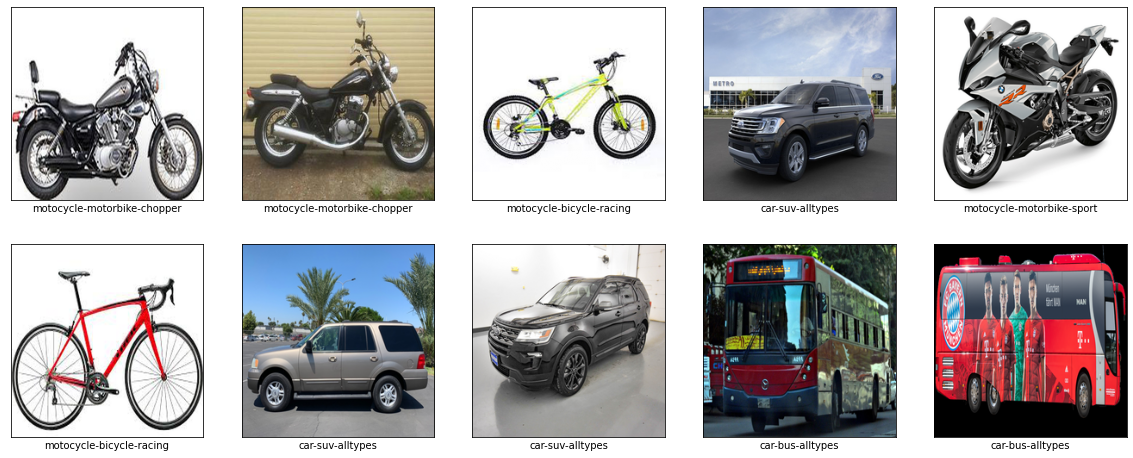

In [ ]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(trainX, trainLabels,rows=2, colums=5, width=20,height=8)


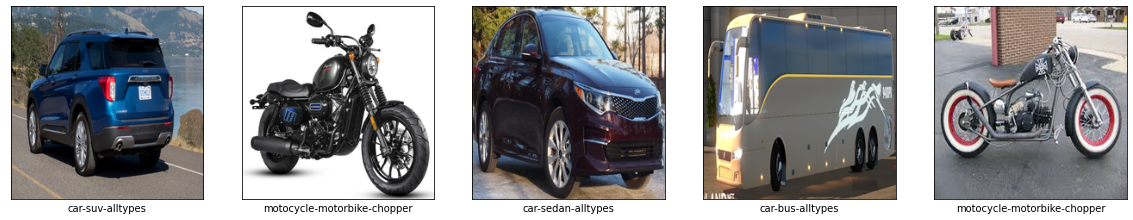

In [ ]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(devX, devLabels,rows=1, colums=5, width=20,height=8)

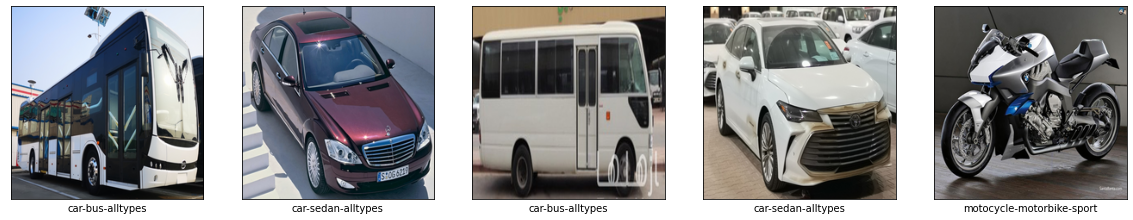

In [ ]:
anis_koubaa_udemy_computer_vision_lib.plot_sample_from_dataset(testX, testLabels,rows=1, colums=5, width=20,height=8)

# Training Configuration

# Data Augmentation

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=20)
	#fill_mode="nearest")
	#brightness_range=[0.2,1.0])
	#horizontal_flip=True)

In [ ]:
# load the network, ensuring the head FC layer sets are left
# off
if (first_time_training==True):
    print('training for first time')
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE,3)))

training for first time


In [ ]:
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(number_of_classes, activation="softmax")(headModel)

In [ ]:
    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = True

    model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
#disable this instruction if you train for the first time
#enable it when you for the second time or after
if (first_time_training==False):
    model = tf.keras.models.load_model(TARGET_CLASSIFICATION_MODEL)

#for layer in model.layers[0:-8]:
#    layer.trainable = False

#    model.summary()

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
#import tf.keras.callbacks.Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle
#!mkdir -p '/content/drive/My Drive/anis-koubaa-projects/car-classification-project/checkpoints'

cp1= ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1, mode='auto')
csv_logger = CSVLogger(LOGFILE_PATH,append=True)

callbacks_list = [cp1,csv_logger]

In [ ]:
#SET THE HYPERPARAMETERS OF THE TRAINING

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
INITIAL_EPOCH=0
EPOCHS = INITIAL_EPOCH+100
BS = 64


# compile our model
print("[INFO] compiling model...")

#opt=tf.keras.optimizers.Adagrad(learning_rate=INIT_LR, initial_accumulator_value=0.1, epsilon=1e-07, name='Adagrad', decay=INIT_LR / EPOCHS)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#opt = SGD (learning_rate=INIT_LR, momentum = 0.9, decay=INIT_LR / EPOCHS)



[INFO] compiling model...


In [ ]:
#COMPILE THE MODEL
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=["accuracy"])

In [ ]:
#create folder if they do not exists
LOG_PATH=PROJECT_PATH+'log/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
LOG_PATH=PROJECT_PATH+'checkpoints/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

In [ ]:
# train the head of the network
print("[INFO] training head...")
history = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(devX, devY),
	validation_steps=len(devX) // BS,
	epochs=EPOCHS, callbacks=callbacks_list, initial_epoch=INITIAL_EPOCH)

[INFO] training head...
Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 1.9371 - accuracy: 0.1874
Epoch 00001: val_accuracy improved from -inf to 0.18667, saving model to /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/checkpoints/mobilenetv2/by-type-mobilenetv2-anis-1-2.h5
9/9 [==============================] - 5s 605ms/step - loss: 1.9371 - accuracy: 0.1874 - val_loss: 1.9114 - val_accuracy: 0.1867
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.8355 - accuracy: 0.3395
Epoch 00002: val_accuracy improved from 0.18667 to 0.45333, saving model to /content/drive/My Drive/udemy-deep-learning-in-practice/03-transfer-learning/03-train-models/checkpoints/mobilenetv2/by-type-mobilenetv2-anis-1-2.h5
9/9 [==============================] - 5s 542ms/step - loss: 1.8355 - accuracy: 0.3395 - val_loss: 1.8215 - val_accuracy: 0.4533
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 1.6963 - accuracy:

In [ ]:
LOG_PATH=PROJECT_PATH+'trained-models/'+model_type+'/'
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)
model.save(TARGET_CLASSIFICATION_MODEL)

# See Results

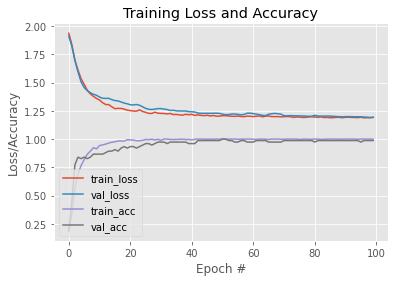

In [ ]:
anis_koubaa_udemy_computer_vision_lib.plot_loss_accuracy_from_csv(LOGFILE_PATH)